<a href="https://colab.research.google.com/github/ChaaruVijay/DSPL-CourseWork/blob/main/DSPL_Catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

Load & Preprocess Data

In [3]:
# Load dataset
cb_model = pd.read_csv("/content/train_cleaned.csv")

In [4]:
# Define Features & Target
X = cb_model[['luxury_sales', 'fresh_sales', 'dry_sales']]
y = cb_model['cluster_category']

In [5]:
# Split Data into Training & Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Hyperparameter Tuning using Grid Search

In [8]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Define CatBoost model
catboost_classifier = CatBoostClassifier(verbose=0, random_seed=42)  # Removed task_type="GPU"

# Define optimized hyperparameter grid (smaller search space)
param_dist = {
    'iterations': [100, 300],  # Reduce iterations to balance speed
    'learning_rate': [0.05, 0.1],  # Focus on optimal learning rates
    'depth': [4, 6],  # Reduce depth options
    'l2_leaf_reg': [1, 3]  # Keep fewer regularization values
    }

# Perform Randomized Search (faster than Grid Search)
random_search = RandomizedSearchCV(
    catboost_classifier,
    param_distributions=param_dist,
    n_iter=10,  # Reduce iterations for speed
    cv=3,  # Reduce cross-validation folds for speed
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
    )

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", random_search.best_params_)

# Train final model with best parameters
best_cb = random_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 6}


Model Evaluation

In [9]:
# Predictions
y_pred = best_cb.predict(X_test)

# Training & Test Accuracy
train_accuracy = accuracy_score(y_train, best_cb.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification Report
print(classification_report(y_test, y_pred))

Training Accuracy: 0.9540
Test Accuracy: 0.9543
              precision    recall  f1-score   support

           1       1.00      0.99      1.00     37792
           2       0.99      1.00      1.00     31010
           3       0.89      0.38      0.53      9778
           4       0.99      1.00      1.00     34485
           5       0.55      0.94      0.69      7905
           6       1.00      0.99      1.00     33841

    accuracy                           0.95    154811
   macro avg       0.90      0.88      0.87    154811
weighted avg       0.97      0.95      0.95    154811



Confusion Matrix

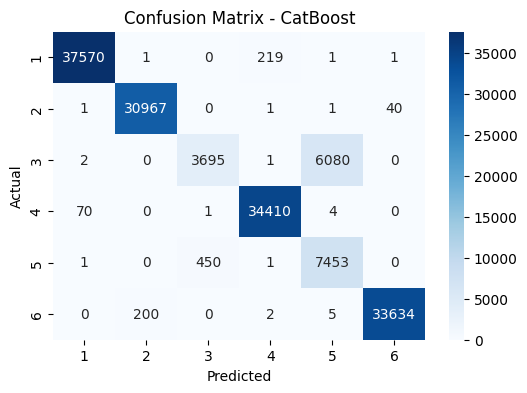

In [10]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - CatBoost')
plt.show()

AUC-ROC Curve

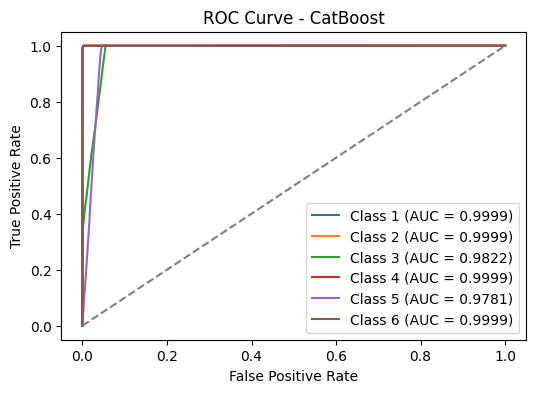

In [14]:
# Compute probabilities for ROC curve
y_probs = best_cb.predict_proba(X_test)

# Assuming 'cluster_category' has more than two classes
# Choose 'ovr' (one-vs-rest) or 'ovo' (one-vs-one) for multi-class handling
auc_score = roc_auc_score(y_test, y_probs, multi_class='ovr')  # Or multi_class='ovo'

# If the target has only two classes, specifying `average='macro'` or 'micro'` might be necessary too.

# Now you can proceed with plotting the ROC curve:
# Plot ROC curve
plt.figure(figsize=(6,4))

# Compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_probs.shape[1]  # Get the number of classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_probs[:, i], pos_label=best_cb.classes_[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {best_cb.classes_[i]} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost')
plt.legend()
plt.show()

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split data into train (70%), validation (15%), and test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Evaluate model on validation data
y_val_pred = best_cb.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Compare with test data
y_test_pred = best_cb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

Validation Accuracy: 0.9543
Test Accuracy: 0.9538


Learning Curve

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/catboost/core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/usr/local/lib/python3.11/dist-packages/catboost/core.py", line 2410, in _fit


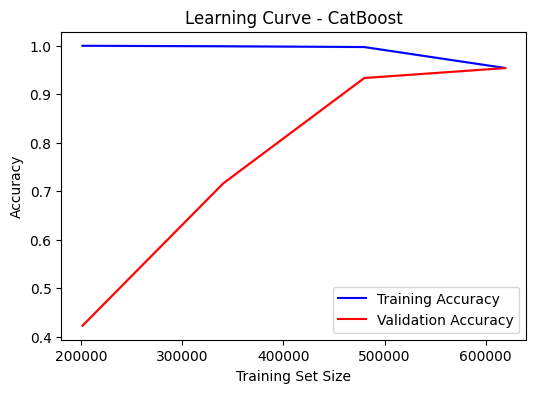

In [16]:
# Import the learning_curve function
from sklearn.model_selection import learning_curve

# Compute learning curve
train_sizes, train_scores, val_scores = learning_curve(best_cb, X, y, cv=5, scoring='accuracy')

# Compute mean and std deviation for training & validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mean, label="Training Accuracy", color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_mean, label="Validation Accuracy", color='red')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve - CatBoost")
plt.legend()
plt.show()

Feature Importance

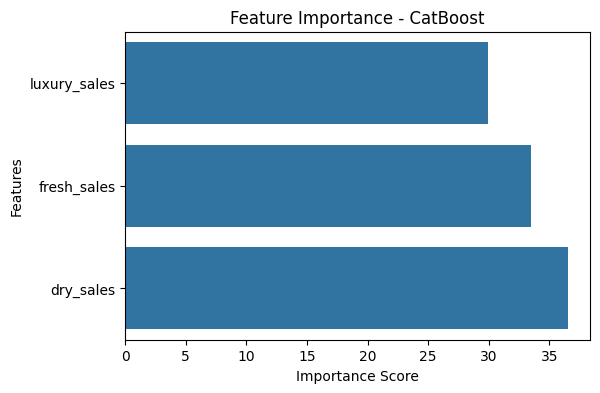

In [17]:
# Get feature importance
feature_importance = best_cb.get_feature_importance()
features = X.columns

# Plot Feature Importance
plt.figure(figsize=(6,4))
sns.barplot(x=feature_importance, y=features)
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance - CatBoost")
plt.show()